# 我想到的一个是找最低点。
这样的话，问题就由一个回归问题变为一个分类问题。  
如以过去N天的(股价，成交量，时间（季度、月份），其它股票、指数、汇率、油价，等等)组成一个特征序列，来预测次日的股价是否是最低点。
最低点的判断依据：未来T天的股价收盘价均不小于预测序列最后一日的收盘价，且未来T天的收盘价最高点大于预测序列最后一日的收盘价的Z%

In [9]:
import pandas as pd
import numpy as np
import tushare as ts
from datetime import datetime, timedelta
from collections import Counter
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.recurrent import GRU, LSTM
from keras.optimizers import Adam
import time
from sklearn.metrics import accuracy_score, classification_report
from keras.models import load_model
import logging

import sys
sys.path.append('/Users/luoyonggui/PycharmProjects/mayiutils_n1/mayiutils/db')
from pymongo_wrapper import PyMongoWrapper

In [2]:
MODULE_NAME = 'stock_predict'
TS_TOKEN = '5fd1639100f8a22b7f86e882e03192009faa72bae1ae93803e1172d5'

In [3]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(MODULE_NAME)

In [4]:
import os
os.chdir('/Users/luoyonggui/PycharmProjects/mayiexamples/finance')
from tushare_utils import ts_code_dict
os.chdir('/Users/luoyonggui/PycharmProjects/mayiapps/finance')

In [5]:
class StockPredict:
    def __init__(self):
        self._pro = ts.pro_api(TS_TOKEN)
        
    def daily(self, ts_code, start_date, end_date):
        '''
        获取每日行情数据
        由于ts的接口一次只能获取1800个交易日（一年大概有250个交易日。约7年）的数据
        :mode
            index: 指数行情
            stock: 个股行情
        '''
        mongo = PyMongoWrapper()

        table = mongo.getCollection('finance', ts_code, )
        
        
        startdate = datetime.strptime(start_date, '%Y%m%d')
        enddate = datetime.strptime(end_date, '%Y%m%d')
        df = pd.DataFrame()
        while enddate.year-startdate.year>6:      
            print(startdate.strftime('%Y%m%d'), (startdate.replace(year=(startdate.year+6))-timedelta(days=1)).strftime('%Y%m%d'))
            t = self._pro.index_daily(ts_code=ts_code, start_date=startdate.strftime('%Y%m%d'), end_date=(startdate.replace(year=(startdate.year+6))-timedelta(days=1)).strftime('%Y%m%d'))
            if not df.empty:
                df = pd.concat([df,t], axis=0, ignore_index=True)
            else:
                df = t
            startdate = startdate.replace(year=(startdate.year+6))
        else:
            print(startdate.strftime('%Y%m%d'),end_date)
            t = self._pro.index_daily(ts_code=ts_code, start_date=startdate.strftime('%Y%m%d'), end_date=end_date)
            if not df.empty:
                df = pd.concat([df,t], axis=0, ignore_index=True)
            else:
                df = t
        df = df.sort_values('trade_date')
        df['trade_date'] = pd.to_datetime(df['trade_date'])
        df.set_index('trade_date', inplace=True)
        return df
    def normlize_field(self, df, fieldnamelist):
        '''
        #设df中某一字段 第一日净值为1
        '''
        df1 = pd.DataFrame()
        df1['ts_code'] = df['ts_code']
        df1['trade_date'] = df['trade_date']
        for f in fieldnamelist:
            df1[f+'_1'] = df.apply(lambda x: x[f]/df.iloc[0][f], axis=1)        
        return df1
    def build_flag(self, df,series_len,pro_len, fieldnamelist):
        '''
        构建训练集

        series_len: 参考的之前的序列范围。如以之前的series_len个序列预测下一个序列，则series_len=series_len
        pro_len: 预测日以后的天数（含预测日）
        '''
        r = list()
        l1 = df['net_worth'].to_list()
        for i in range(series_len,(df.shape[0]-pro_len)):
            final_list = list()
            laa = l1[i:i+pro_len]
            #最低点和买点的关系：最低点一定是买点，买点不一定是最低点
            #买点特征
            #买点日之后14日最高收盘价涨幅超过0.05，最低价不得低于买点日收盘价
            #最低点的特征：在买点特征的基础上
            #最低日收盘价低于前一日收盘价

            f1 = 0 # 买点标志 1表示买点
            f2 = 0 # 最低点标志 1表示最低点
            if (max(laa) - l1[i])/l1[i] > 0.05 and min(laa[1:]) > l1[i]:#未来pro_len日最高收盘价涨幅超过0.05
                f1 = 1
                if l1[i] < l1[i-1]:
                    f2 = 1
            final_list.append(df[fieldnamelist].values[(i-series_len) : i])
            final_list.append(f1)
            final_list.append(f2)
            r.append(final_list)    
        return r
    def getNum(self, ll):
        '''
        获取买点、最低点的个数
        '''
        y = [(i[-2],i[-1]) for i in ll]
        return Counter(y)
    def preprocess(self,ll,balance=True):
        '''
        数据预处理，获得可用于训练的set
        '''
        ll1 = [i for i in ll if i[1]==1]#买点数据
        #均衡数据
        ll2 = ll
        if balance:
            ll2 += ll1* (round(len(ll)/len(ll1))-1)
        ll3 = [(i[1],i[2]) for i in ll2]
        x = np.array([i[0] for i in ll2])
        y1 = np.array([[i[1]] for i in ll2])#买点
        y2 = np.array([[i[2]] for i in ll2])#最低点
        print(Counter(ll3))
        return x,np_utils.to_categorical(y1,num_classes=2),np_utils.to_categorical(y2,num_classes=2)
    def buildModel(self, n):
        '''
        # 创建模型
        n 考虑的特征的个数
        '''
        model = Sequential()

        # 循环神经网络
        model.add(LSTM(
            units = 256, # 输出
            input_shape = (180,n), #输入
        ))
        model.add(Dense(200,activation='tanh'))
        # 输出层
        model.add(Dense(2,activation='softmax'))

        # 定义优化器
        adam = Adam(lr=1e-4)

        # 定义优化器，loss function，训练过程中计算准确率
        model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
        print(model.summary())
        self._model = model
    def train(self,x_train,y_train,batch_size=128,epochs=300):
        # 训练模型
        start = time.time()
        self._model.fit(x_train,y_train,batch_size,epochs)
        print('@ Total Time Spent: %.2f seconds' % (time.time() - start))
    def evaluate(self,x_test,y_test):
        # 评估模型
        loss,accuracy = t._model.evaluate(x_test,y_test)
        print('test loss',loss)
        print('test accuracy',accuracy)
        return loss,accuracy
    def build_x(self, df,series_len, start):
        '''
        构建预测序列

        series_len: 参考的之前的序列范围。如以之前的series_len个序列预测下一个序列，则series_len=series_len
        '''
        ll = list()
        l1 = list(df['close_1'])
        l4 = list(df['vol_1'])
        l5 = list(df['amount_1'])
        for i in range(df.shape[0]-start,df.shape[0]):
            final_list = list()
            l2 = l1[i-series_len : i]
            ll.append(list(zip(l1[i-series_len : i],l4[i-series_len : i],l5[i-series_len : i])))    
        return ll
    def predict(self, x_list):
        '''
        x_list: 预测序列的list
        '''
        r = self._model.predict(x_list)
        return r
    def loadModel(self, filepath):
        self._model = load_model(filepath)
    def evaluateScore(self, y_test, y_predict):
        score = accuracy_score(np.argmax(y_test,axis=1), np.argmax(y_predict,axis=1))
        c  = classification_report(np.argmax(y_test,axis=1), np.argmax(y_predict,axis=1))
        print(score)
        print(c)

In [6]:
t = tt()

In [7]:
ts_code_dict['上证指数']

'000001.SH'

In [8]:
df = t.daily(ts_code_dict['上证指数'],start_date='20010101', end_date='20180730')

20010101 20061231


ConnectionError: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))

* vol: 成交量
* amount: 成交额

In [62]:
df = df[['ts_code', 'close','pct_chg', 'vol', 'amount']]
df.tail()

,ts_code,close,pct_chg,vol,amount
trade_date,,,,,
2018-07-24,000001.SH,2905.5618,1.6093,229578307.0,228701875.5
2018-07-25,000001.SH,2903.6467,-0.0659,167800207.0,166412077.1
2018-07-26,000001.SH,2882.2254,-0.7377,168428202.0,157496681.8
2018-07-27,000001.SH,2873.5938,-0.2995,146371610.0,132419371.8
2018-07-30,000001.SH,2869.0495,-0.1581,151652249.0,145988585.4


In [28]:
import ffn

In [30]:
ffn.to_returns(df['close']).tail()

trade_date
2019-07-24    0.008046
2019-07-25    0.004817
2019-07-26    0.002445
2019-07-29   -0.001200
2019-07-30    0.003853
Name: close, dtype: float64

In [31]:
ffn.to_returns(df['close']).std()

0.01578708007227872

In [32]:
df['pct_chg'].std()

1.5786759729417088

In [34]:
#计算最大回测
ffn.calc_max_drawdown((1+df['pct_chg']/100).cumprod())

-0.7198464559099702

In [36]:
df.head()

,ts_code,close,pct_chg,amount
trade_date,,,,
2001-01-02,000001.SH,2103.469,1.4465,1.340509e+07
2001-01-03,000001.SH,2123.899,0.9713,1.751683e+07
2001-01-04,000001.SH,2117.405,-0.3058,1.429525e+07
2001-01-05,000001.SH,2125.300,0.3729,1.484424e+07
2001-01-08,000001.SH,2102.064,-1.0933,1.588766e+07


## 以起始第一天的开盘价为净值1，计算每日净值

In [63]:
df['net_worth'] = (1+df['pct_chg']/100).cumprod()

## 以起始第一天的成交额为净值1，计算每日成交额净值

In [64]:
st = (1+ffn.to_returns(df['amount'])).cumprod()
st.loc['2001-01-02'] = 1
df['net_amount'] = st

In [65]:
st = (1+ffn.to_returns(df['vol'])).cumprod()
st.loc['2001-01-02'] = 1
df['net_vol'] = st

In [66]:
df.head()

,ts_code,close,pct_chg,vol,amount,net_worth,net_amount,net_vol
trade_date,,,,,,,,
2001-01-02,000001.SH,2103.469,1.4465,18650746.0,1.340509e+07,1.014465,1.000000,1.000000
2001-01-03,000001.SH,2123.899,0.9713,17157673.0,1.751683e+07,1.024318,1.306729,0.919946
2001-01-04,000001.SH,2117.405,-0.3058,13423541.0,1.429525e+07,1.021186,1.066404,0.719732
2001-01-05,000001.SH,2125.300,0.3729,13288175.0,1.484424e+07,1.024994,1.107358,0.712474
2001-01-08,000001.SH,2102.064,-1.0933,14787085.0,1.588766e+07,1.013788,1.185196,0.792841


In [67]:
df['net_worth'].max()

2.938042105252932

## 绘制时间序列图

In [51]:
import matplotlib.pyplot as plt
# 支持中文显示
plt.rcParams['font.sans-serif'] = ['STFangsong']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

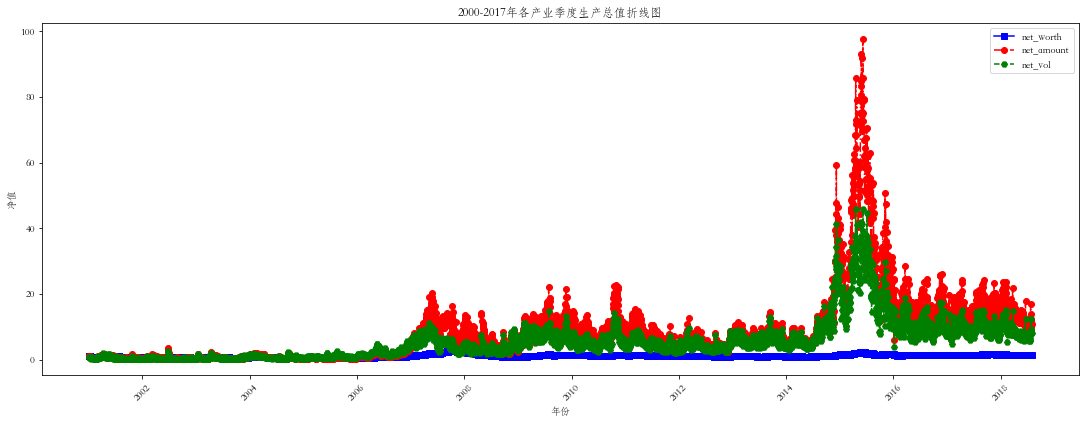

In [68]:
fig =plt.figure(figsize=(18,7)) # 创建画布
ax = fig.add_axes([0.15,0.2,0.8,0.7]) # Axes是画布上的绘图区域
plt.plot(df.index, df['net_worth'],'bs-',
       df.index, df['net_amount'],'ro-.',
       df.index, df['net_vol'],'gH--')## 绘制折线图
plt.xlabel('年份')## 添加横轴标签
plt.ylabel('净值')## 添加y轴名称
plt.xticks(rotation=45)
plt.title('2000-2017年各产业季度生产总值折线图')## 添加图表标题
plt.legend(['net_worth','net_amount','net_vol'])
# plt.savefig('2000-2017年季度各产业生产总值折线图.pdf')
plt.show()

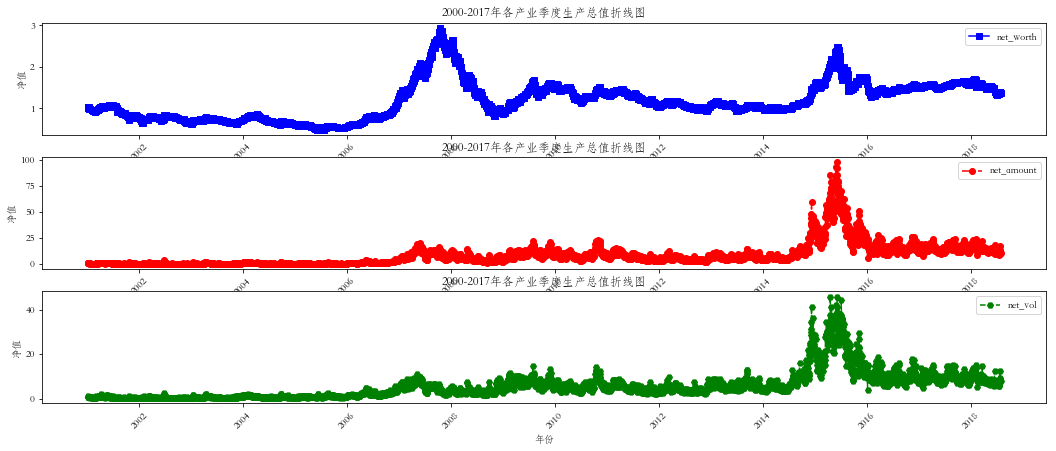

In [69]:
fig =plt.figure(figsize=(18,7)) # 创建画布
## 子图
ax3 = fig.add_subplot(3,1,1)
plt.plot(df.index, df['net_worth'],'bs-')
plt.xlabel('年份')## 添加横轴标签
plt.ylabel('净值')## 添加y轴名称
plt.xticks(rotation=45)
plt.title('2000-2017年各产业季度生产总值折线图')## 添加图表标题
plt.legend(['net_worth'])
## 子图
ax3 = fig.add_subplot(3,1,2)
plt.plot(df.index, df['net_amount'],'ro-.')
plt.xlabel('年份')## 添加横轴标签
plt.ylabel('净值')## 添加y轴名称
plt.xticks(rotation=45)
plt.title('2000-2017年各产业季度生产总值折线图')## 添加图表标题
plt.legend(['net_amount'])
## 子图
ax3 = fig.add_subplot(3,1,3)
plt.plot(df.index, df['net_vol'],'gH--')## 绘制折线图
plt.xlabel('年份')## 添加横轴标签
plt.ylabel('净值')## 添加y轴名称
plt.xticks(rotation=45)
plt.title('2000-2017年各产业季度生产总值折线图')## 添加图表标题
plt.legend(['net_vol'])
# plt.savefig('2000-2017年季度各产业生产总值折线图.pdf')
plt.show()

## 构建训练集

In [71]:
fieldlist = ['net_worth','net_vol', 'net_amount']
ll = t.build_flag(df,180,15,fieldlist)

### 问题：数据不均衡

In [74]:
yy = [(i[-2],i[-1]) for i in ll]
Counter(yy)

Counter({(0, 0): 3582, (1, 1): 215, (1, 0): 268})

In [75]:
# 买点
y = [(i[1]) for i in ll]
Counter(y)

Counter({0: 3582, 1: 483})

In [76]:
y = np_utils.to_categorical(y,num_classes=2)

In [78]:
y[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [77]:
x = np.array([i[0] for i in ll])

In [80]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=14, stratify=y)

## lstm_model

### 问题：训练参数远大于训练集量
* dropout
* 数据增强

In [73]:
model = t.buildModel(len(fieldlist))

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               266240    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               51400     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 402       
Total params: 318,042
Trainable params: 318,042
Non-trainable params: 0
_________________________________________________________________
None


In [86]:
t.train(x_train, y_train, epochs=150)

Epoch 1/150
2845/2845 [==============================] - 17s 6ms/step - loss: 0.3396 - acc: 0.8812
Epoch 2/150
2845/2845 [==============================] - 19s 7ms/step - loss: 0.3391 - acc: 0.8812
Epoch 3/150
2845/2845 [==============================] - 18s 6ms/step - loss: 0.3334 - acc: 0.8812
Epoch 4/150
2845/2845 [==============================] - 17s 6ms/step - loss: 0.3301 - acc: 0.8812
Epoch 5/150
2845/2845 [==============================] - 19s 7ms/step - loss: 0.3273 - acc: 0.8812
Epoch 6/150
2845/2845 [==============================] - 19s 7ms/step - loss: 0.3305 - acc: 0.8822
Epoch 7/150
2845/2845 [==============================] - 17s 6ms/step - loss: 0.3363 - acc: 0.8812
Epoch 8/150
2845/2845 [==============================] - 19s 7ms/step - loss: 0.3266 - acc: 0.8815
Epoch 9/150
2845/2845 [==============================] - 18s 6ms/step - loss: 0.3229 - acc: 0.8812
Epoch 10/150
2845/2845 [==============================] - 18s 6ms/step - loss: 0.3191 - acc: 0.8812
Epoch 11/

2845/2845 [==============================] - 19s 7ms/step - loss: 0.2786 - acc: 0.8946
Epoch 84/150
2845/2845 [==============================] - 21s 7ms/step - loss: 0.2772 - acc: 0.8984
Epoch 85/150
2845/2845 [==============================] - 21s 7ms/step - loss: 0.2738 - acc: 0.8977
Epoch 86/150
2845/2845 [==============================] - 19s 7ms/step - loss: 0.2748 - acc: 0.8970
Epoch 87/150
2845/2845 [==============================] - 20s 7ms/step - loss: 0.2740 - acc: 0.8988
Epoch 88/150
2845/2845 [==============================] - 20s 7ms/step - loss: 0.2773 - acc: 0.8960
Epoch 89/150
2845/2845 [==============================] - 19s 7ms/step - loss: 0.2707 - acc: 0.8963
Epoch 90/150
2845/2845 [==============================] - 19s 7ms/step - loss: 0.2740 - acc: 0.8953
Epoch 91/150
2845/2845 [==============================] - 18s 6ms/step - loss: 0.2749 - acc: 0.8953
Epoch 92/150
2845/2845 [==============================] - 19s 7ms/step - loss: 0.2729 - acc: 0.8946
Epoch 93/150


## 评估

In [87]:
# 评估模型
loss,accuracy = t._model.evaluate(x_test,y_test)

print('test loss',loss)
print('test accuracy',accuracy)

1220/1220 [==============================] - 3s 2ms/step
test loss 0.29300299980601324
test accuracy 0.8909836065573771


In [88]:
x_p,y1_p,y2_p = t.preprocess(ll[-250:],balance=False)

Counter({(0, 0): 241, (1, 0): 6, (1, 1): 3})


In [89]:
y_predict = t.predict(x_p)

In [92]:
t.evaluateScore(y1_p, y_predict)

0.968
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       241
           1       1.00      0.11      0.20         9

   micro avg       0.97      0.97      0.97       250
   macro avg       0.98      0.56      0.59       250
weighted avg       0.97      0.97      0.96       250



## 可视化

In [94]:
from pyecharts.charts import Line

In [96]:
df2 = df.iloc[180:(df.shape[0]-15)]
df2['buy'] = [i[1] for i in ll]
df2['min'] = [i[1] for i in ll]

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [97]:
df2.head()

,ts_code,close,pct_chg,vol,amount,net_worth,net_amount,net_vol,buy,min
trade_date,,,,,,,,,,
2001-10-09,000001.SH,1744.640,1.0487,2720976.0,3151315.983,0.841404,0.235083,0.145891,0,0
2001-10-10,000001.SH,1686.612,-3.3261,3931351.0,4675751.398,0.813418,0.348804,0.210788,0,0
2001-10-11,000001.SH,1638.326,-2.8629,4370308.0,4937634.568,0.790131,0.368340,0.234323,0,0
2001-10-12,000001.SH,1691.326,3.2350,7239256.0,8113369.515,0.815692,0.605245,0.388148,0,0
2001-10-15,000001.SH,1687.280,-0.2392,4588758.0,5149456.451,0.813740,0.384142,0.246036,0,0


In [98]:
dft = df2.iloc[-250:]

In [99]:
dft['y1_predict'] = np.argmax(y_predict,axis=1)

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [101]:
dft.head()

,ts_code,close,pct_chg,vol,amount,net_worth,net_amount,net_vol,buy,min,y1_predict
trade_date,,,,,,,,,,,
2017-07-03,000001.SH,3195.9116,0.1092,140305717.0,156575784.3,1.541306,11.680319,7.522794,0,0,0
2017-07-04,000001.SH,3182.8039,-0.4101,141114967.0,161454562.3,1.534985,12.044269,7.566184,0,0,0
2017-07-05,000001.SH,3207.1342,0.7644,148296483.0,173554012.0,1.546718,12.946869,7.951236,0,0,0
2017-07-06,000001.SH,3212.4440,0.1656,175809287.0,202209616.9,1.549280,15.084535,9.426394,0,0,0
2017-07-07,000001.SH,3217.9567,0.1716,176715416.0,201938313.2,1.551938,15.064296,9.474978,0,0,0


In [145]:
dft['aa'] = dft.index

dft['aa'] = dft['aa'].map(str).map(lambda s: s[:10])

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [126]:
import pyecharts.options as opts
from pyecharts.charts import Line

In [147]:
dft.head()

,ts_code,close,pct_chg,vol,amount,net_worth,net_amount,net_vol,buy,min,y1_predict,aa
trade_date,,,,,,,,,,,,
2017-07-03,000001.SH,3195.9116,0.1092,140305717.0,156575784.3,1.541306,11.680319,7.522794,0,0,0,2017-07-03
2017-07-04,000001.SH,3182.8039,-0.4101,141114967.0,161454562.3,1.534985,12.044269,7.566184,0,0,0,2017-07-04
2017-07-05,000001.SH,3207.1342,0.7644,148296483.0,173554012.0,1.546718,12.946869,7.951236,0,0,0,2017-07-05
2017-07-06,000001.SH,3212.4440,0.1656,175809287.0,202209616.9,1.549280,15.084535,9.426394,0,0,0,2017-07-06
2017-07-07,000001.SH,3217.9567,0.1716,176715416.0,201938313.2,1.551938,15.064296,9.474978,0,0,0,2017-07-07


In [148]:
gg = [{'coord':[line.aa, line.net_worth]} for line in dft[dft['buy']==1].itertuples()]

In [149]:
line = Line()
line.add_xaxis(dft.aa.to_list())
line.add_yaxis('net_worth', dft['net_worth'].map(lambda a: round(a,2)).to_list(), markpoint_opts=opts.MarkPointOpts(data=gg))
line.add_yaxis('net_amount', dft['net_amount'].map(lambda a: round(a,2)).to_list())
line.add_yaxis('net_vol', dft['net_vol'].map(lambda a: round(a,2)).to_list())
line.set_global_opts(title_opts=opts.TitleOpts(title="Line-基本示例"), 
                     toolbox_opts=opts.ToolboxOpts(is_show=True), # 显示工具箱配置项
                    )
line.render_notebook()

In [150]:
gg = [{'coord':[line.aa, line.net_worth]} for line in dft[dft['y1_predict']==1].itertuples()]

In [151]:
line = Line()
line.add_xaxis(dft.aa.to_list())
line.add_yaxis('net_worth', dft['net_worth'].map(lambda a: round(a,2)).to_list(), markpoint_opts=opts.MarkPointOpts(data=gg))
line.add_yaxis('net_amount', dft['net_amount'].map(lambda a: round(a,2)).to_list())
line.add_yaxis('net_vol', dft['net_vol'].map(lambda a: round(a,2)).to_list())
line.set_global_opts(title_opts=opts.TitleOpts(title="Line-基本示例"), 
                     toolbox_opts=opts.ToolboxOpts(is_show=True), # 显示工具箱配置项
                    )
line.render_notebook()

## 模型保存

In [158]:
t._model.save('data_gen/model_lstm.h5')